## RNN

Kaggle Sentiment140 dataset: https://www.kaggle.com/kazanova/sentiment140

Embedding Weights for Transfer Learning: https://nlp.stanford.edu/projects/glove/

Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Question.ipynb

Coursera Colab link Answers:  https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Answer.ipynb


In [0]:
import json
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers



training_size = 160000   # Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion = .1

vocab_size = 1000  # vocabulary size for the tokenizer
oov_tok = "<OOV>"

max_length = 128  # text padding size
trunc_type='post'
padding_type='post'

embedding_dim = 100


2.2.0-rc1


In [0]:

# !!! Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv



--2020-03-28 16:37:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.112, 2607:f8b0:4007:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  82.1MB/s    in 2.8s    

2020-03-28 16:38:01 (82.1 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
num_sentences = 0

# with open("/tmp/training_cleaned.csv") as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     for row in reader:
#       # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
#       # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
#         list_item=[]
#         # YOUR CODE HERE
#         num_sentences = num_sentences + 1
#         corpus.append(list_item)

df = pd.read_csv("/tmp/training_cleaned.csv", header=None, sep=',', engine='python')

# Shuffling data
df = df.reindex(np.random.permutation(df.index))

num_sentences = df.shape[0]  # data set size

# Selecting col 5 (text data) and col 0 (labels). Note: it's still a pd df not yet a list!
corpus_df = df.iloc[:,[5,0]]
corpus_df.columns = ["Texts", "Labels"]  # not really needed

# Converting labels 0,4 to 0,1:
corpus_df.iloc[:,1] = corpus_df.iloc[:,1].apply(lambda val : 0 if val==0 else 1)
# corpus_df['Labels [0,1]'] = corpus_df['Labels'].apply(lambda val : 0 if val==0 else 1)  # alternative

# corpus = []
# corpus = [corpus_df.iloc[:,0].astype(str).tolist(), corpus_df.iloc[:,1].values]



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
# print(df.head())
# print(df.columns)
# print(df.iloc[0,:])
# print(df.iloc[:,0])
# print(df.iloc[:,5])
# print(df.shape)

print(corpus_df.shape)
print(corpus_df.head())

# print(len(corpus))


(1600000, 2)
                                                     Texts  Labels
913333   @Scorch_Mom Emailed you - it'll be on the porc...       1
666206   @MsSexyPants what a f:ed up thing to say. mind...       0
1410306                    @slowjo Hi, thanx 4 following.        1
1001211                        4ever! Haha love this song        1
961781   @modulation   Now I always told u u could flip...       1


In [0]:
print(num_sentences)
# print(len(corpus))
# print(corpus[1])
print(corpus_df.shape[0])
print(corpus_df.iloc[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
Texts     @MsSexyPants what a f:ed up thing to say. mind...
Labels                                                    0
Name: 666206, dtype: object


In [0]:
# Splitting the Dataset into list of Strings and array of Labels:

sentences=[]
labels=[]
# random.shuffle(corpus)  the pd df is already shuffled above!
# for x in range(training_size):
#     sentences.append(# YOUR CODE HERE)
#     labels.append(# YOUR CODE HERE)
sentences = corpus_df.iloc[:training_size,0].astype(str).tolist()   # putting the text examples in a list
labels = corpus_df.iloc[:training_size,1].values   # putting the labels in a np array


# Tokenizing the example texts:

tokenizer = Tokenizer(oov_token=oov_tok)  #, num_words=vocab_size)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)   
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) 


# Splitting the Dataset into Training and Validation Datasets:

split = int((1-test_portion) * training_size)

test_sequences = padded[split:]
training_sequences = padded[:split]
test_labels = labels[split:]
training_labels = labels[:split]

In [0]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

print(len(training_sequences))
print(len(test_sequences))
print(len(training_labels))
print(len(test_labels))

138716
2
144000
16000
144000
16000


In [0]:
# TRANSFER LEARNING  OF THE EMBEDDING WEIGHTS!!!!
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:embedding_dim+1], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-03-28 17:04:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.80, 2607:f8b0:4007:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   255MB/s    in 1.3s    

2020-03-28 17:04:01 (255 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
print(len(embeddings_matrix))
# Expected Output
# 138859

# Why it's one more than the vocab_size?? I guess it's becuase of the oov_token

138717


In [0]:
# Defining the NN:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),  # we don't have to train it as we use transfer learning
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(15)),
    # tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    # Alternative from Coursera:
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(lr=0.0007), loss='binary_crossentropy', metrics=['accuracy'])


model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 128, 100)          13871700  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 30)                13920     
_________________________________________________________________
dense_10 (Dense)             (None, 15)                465       
_________________________________________________________________
dropout_5 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 13,886,101
Trainable params: 14,401
Non-trainable params: 13,871,700
_________________________________________________________________


In [0]:
# Training the NN:

num_epochs = 50

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.999
    if logs['accuracy']>targ :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback=myCallback()

history = model.fit(training_sequences, training_labels, epochs=num_epochs, callbacks=[callback], validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 54s - loss: 0.5639 - accuracy: 0.7103 - val_loss: 0.5399 - val_accuracy: 0.7280
Epoch 2/50
4500/4500 - 54s - loss: 0.5093 - accuracy: 0.7514 - val_loss: 0.4962 - val_accuracy: 0.7612
Epoch 3/50
4500/4500 - 54s - loss: 0.4922 - accuracy: 0.7626 - val_loss: 0.4929 - val_accuracy: 0.7592
Epoch 4/50
4500/4500 - 54s - loss: 0.4812 - accuracy: 0.7695 - val_loss: 0.4797 - val_accuracy: 0.7698
Epoch 5/50
4500/4500 - 54s - loss: 0.4736 - accuracy: 0.7751 - val_loss: 0.4771 - val_accuracy: 0.7723
Epoch 6/50
4500/4500 - 54s - loss: 0.4666 - accuracy: 0.7785 - val_loss: 0.4767 - val_accuracy: 0.7751
Epoch 7/50
4500/4500 - 54s - loss: 0.4619 - accuracy: 0.7813 - val_loss: 0.4760 - val_accuracy: 0.7774
Epoch 8/50
4500/4500 - 54s - loss: 0.4580 - accuracy: 0.7842 - val_loss: 0.4706 - val_accuracy: 0.7757
Epoch 9/50
4500/4500 - 54s - loss: 0.4550 - accuracy: 0.7861 - val_loss: 0.4689 - val_accuracy: 0.7798
Epoch 10/50
4500/4500 - 54s - loss: 0.4517 - accuracy: 0.7864 - val_loss:

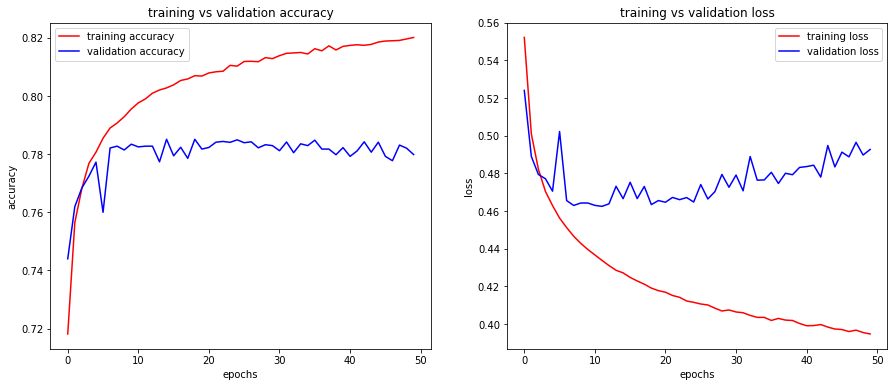

In [0]:

# import matplotlib.pyplot as plt

# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc=history.history['acc']
# val_acc=history.history['val_acc']
# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs=range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot(epochs, acc, 'r')
# plt.plot(epochs, val_acc, 'b')
# plt.title('Training and validation accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Accuracy", "Validation Accuracy"])

# plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot(epochs, loss, 'r')
# plt.plot(epochs, val_loss, 'b')
# plt.title('Training and validation loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Loss", "Validation Loss"])

# plt.figure()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()


# Expected Output
# A chart where the validation loss does not increase sharply!